In [1]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import torch.utils.data as data
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

# Set random seed for reproducibility
SEED = 87
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [2]:
def print_model(encoder, decoder):
    print("============== Encoder ==============")
    print(encoder)
    print("============== Decoder ==============")
    print(decoder)
    print("")

In [3]:
def create_model():
    autoencoder = Autoencoder()
    print_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder


In [4]:
def create_model1(encoder):
    autoencoder = AutoEncoder1(encoder)
    print_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder

In [5]:
def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [6]:
def imshow(img):
    npimg = img.cpu().detach().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [8]:
class CustomDataset(data.Dataset):
    def __init__(self, size=1000):
        indexes = random.sample(range(0, 50000), size)
        group1 = indexes[:size//2]
        group2 = indexes[size//2:]
        self.train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
        self.indexes = []
        for i in group1:
            for j in group2:
                self.indexes.append((i, j))
        
    def __len__(self):
        return len(self.indexes)
    
    def __getitem__(self, idx):
        index1, index2 = self.indexes[idx]
        img1 = self.train_set[index1][0]
        img2 = self.train_set[index2][0]
        result = img1 + img2
        result = result / 2
        return result, (img1, img2)
        

In [9]:
custom_set = CustomDataset(1000)
custom_loader = torch.utils.data.DataLoader(custom_set, batch_size=16,
                                          shuffle=True, num_workers=2)

NameError: name 'transform' is not defined

In [ ]:
class AutoEncoder1(nn.Module):
    def __init__(self, encoder):
        super(AutoEncoder1, self).__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
# Create model
autoencoder1 = create_model1(autoencoder.encoder)

In [ ]:
for i, param in enumerate(autoencoder1.parameters()):
    print(i, param.size(), param.requires_grad)

In [ ]:
for i, param in enumerate(autoencoder1.parameters()):
    if i < 6:
        param.requires_grad = False

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, autoencoder1.parameters()))
epochs = 20

In [ ]:
print("Loading checkpoint...")
autoencoder1.load_state_dict(torch.load("/kaggle/input/cifar10-encoder/weights/autoencoder1.pkl"))

In [ ]:
for i, (inputs, (outputs1, outputs2)) in enumerate(custom_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    imshow(inputs[0])
    imshow(outputs1[0])
    imshow(outputs2[0])
    break

In [ ]:
autoencoder1

In [ ]:
epoch_counter = 0
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, (outputs1, outputs2)) in enumerate(custom_loader, 0):
        inputs = get_torch_vars(inputs)
        outputs1 = get_torch_vars(outputs1)
        outputs2 = get_torch_vars(outputs2)
        # ============ Forward ============
        encoded, outputs = autoencoder1(inputs)
        loss = criterion(outputs, outputs1)
        # ============ Backward ============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    if epoch_counter == 4:
        epoch_counter = -1
        if not os.path.exists('./weights'):
            os.mkdir('./weights')
        torch.save(autoencoder1.state_dict(), "./weights/autoencoder1.pkl")
    epoch_counter += 1
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(autoencoder1.state_dict(), "./weights/autoencoder1.pkl")

In [ ]:
autoencoder1

In [ ]:
for i, (inputs, (outputs1, outputs2)) in enumerate(custom_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image: ")
    imshow(autoencoder1(inputs[0])[1])
    break

In [ ]:
test_set = CustomDataset(1000)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16,
                                          shuffle=True, num_workers=2)

In [ ]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image: ")
    imshow(autoencoder1(inputs[0])[1])
    break

In [ ]:
autoencoder2 = create_model1(autoencoder.encoder)

In [ ]:
print("Loading checkpoint...")
autoencoder2.load_state_dict(torch.load("/kaggle/input/cifar10-encoder/weights/autoencoder2.pkl"))

In [ ]:
for i, param in enumerate(autoencoder2.parameters()):
    if i < 6:
        param.requires_grad = False

In [ ]:
for i, param in enumerate(autoencoder2.parameters()):
    print(i, param.size(), param.requires_grad)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, autoencoder2.parameters()))
epochs = 50

In [ ]:
epoch_counter = 0
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, (outputs1, outputs2)) in enumerate(custom_loader, 0):
        inputs = get_torch_vars(inputs)
        outputs1 = get_torch_vars(outputs1)
        outputs2 = get_torch_vars(outputs2)
        # ============ Forward ============
        encoded, outputs = autoencoder2(inputs)
        loss = criterion(outputs, outputs2)
        # ============ Backward ============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    epoch_counter += 1
    if epoch_counter == 4:
        if not os.path.exists('./weights'):
            os.mkdir('./weights')
        torch.save(autoencoder2.state_dict(), "./weights/autoencoder2.pkl")
        epoch_counter = -1
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(autoencoder2.state_dict(), "./weights/autoencoder2.pkl")

In [ ]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image: ")
    imshow(autoencoder2(inputs[0])[1])
    break

In [ ]:
class MainAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder1, decoder2):
        super(MainAutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder1 = decoder1
        self.decoder2 = decoder2
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded1 = self.decoder1(encoded)
        decoded2 = self.decoder2(encoded)
        return encoded, decoded1, decoded2

In [ ]:
def create_main_model(encoder, decoder1, decoder2):
    autoencoder = MainAutoEncoder(encoder, decoder1, decoder2)
#     print_model(autoencoder.encoder, autoencoder.decoder1, autoencoder.decoder2)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder

In [ ]:
main_model = create_main_model(autoencoder.encoder, autoencoder1.decoder, autoencoder2.decoder)
main_model

In [ ]:
print("Loading checkpoint...")
main_model.load_state_dict(torch.load("/kaggle/input/cifar10-encoder/weights/main_model.pkl"))

In [ ]:
for index, param in enumerate(main_model.parameters()):
    print(index, param.size(), param.requires_grad)

In [ ]:
for index, param in enumerate(main_model.parameters()):
    param.requires_grad = True

In [ ]:
for index, param in enumerate(main_model.parameters()):
    print(index, param.size(), param.requires_grad)

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, main_model.parameters()))
epochs = 50

In [ ]:
epoch_counter = 0
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, (outputs1, outputs2)) in enumerate(custom_loader, 0):
        inputs = get_torch_vars(inputs)
        outputs1 = get_torch_vars(outputs1)
        outputs2 = get_torch_vars(outputs2)
        # ============ Forward ============
        encoded, output1, output2 = main_model(inputs)
        loss = (criterion(output1, outputs1) + criterion(output2, outputs2)) / 2
        # ============ Backward ============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    epoch_counter += 1
    if epoch_counter == 4:
        if not os.path.exists('./weights'):
            os.mkdir('./weights')
        torch.save(main_model.state_dict(), "./weights/main_model.pkl")
        epoch_counter = -1
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(main_model.state_dict(), "./weights/main_model.pkl")

In [ ]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image 1: ")
    imshow(main_model(inputs[0])[1])
    print("predicted image 2: ")
    imshow(main_model(inputs[0])[2])
    break

### Idea 2:

Customise encoder and decoder for denoising mean image and convert it to first image. Then we use $x_2 = 2 \times \frac{x_1 + x_2}{2} - x_1$ to discover second image

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
model2 = create_model()
model2

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters())
epochs = 50

In [ ]:
epoch_counter = 0
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, (outputs1, outputs2)) in enumerate(custom_loader, 0):
        inputs = get_torch_vars(inputs)
        outputs1 = get_torch_vars(outputs1)
        # ============ Forward ============
        encoded, outputs = model2(inputs)
        loss = criterion(outputs, outputs1)
        # ============ Backward ============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    epoch_counter += 1
    if epoch_counter == 4:
        if not os.path.exists('./weights'):
            os.mkdir('./weights')
        torch.save(model2.state_dict(), "./weights/model2.pkl")
        epoch_counter = -1
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(model2.state_dict(), "./weights/model2.pkl")

In [ ]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image 1: ")
    imshow(main_model(inputs[0])[1])
    print("predicted image 2: ")
    imshow(main_model(inputs[0])[2])
    break

In [ ]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image 1: ")
    imshow(model2(inputs[0])[1])
    print("predicted image 2: ")
    imshow(2 * inputs[0] - model2(inputs[0])[1])
    break

# Increase Latent Space Dimension

In [10]:
class BiggerAutoencoder(nn.Module):
    def __init__(self):
        super(BiggerAutoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [12]:
def create_bigger_model():
    autoencoder = BiggerAutoencoder()
    print_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder

In [14]:
bigger_encoder = create_bigger_model()

# Load data
transform = transforms.Compose(
    [transforms.ToTensor()
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

custom_set = CustomDataset(1000)
custom_loader = torch.utils.data.DataLoader(custom_set, batch_size=16,
                                          shuffle=True, num_workers=2)

test_set = CustomDataset(1000)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16,
                                          shuffle=True, num_workers=2)


============== Encoder ==============
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
)
============== Decoder ==============
Sequential(
  (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): Sigmoid()
)

Model moved to GPU in order to speed up training.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
print("Loading checkpoint...")
bigger_encoder.load_state_dict(torch.load("/kaggle/input/cifar10-encoder/weights/bigger_encoder.pkl"))

Loading checkpoint...


<All keys matched successfully>

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(bigger_encoder.parameters())
epochs = 5

In [17]:
epoch_counter = 0
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, _) in enumerate(custom_loader, 0):
        inputs = get_torch_vars(inputs)
        # ============ Forward ============
        encoded, outputs = bigger_encoder(inputs)
        loss = criterion(outputs, inputs)
        # ============ Backward ============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    epoch_counter += 1
    if epoch_counter == 4:
        if not os.path.exists('./weights'):
            os.mkdir('./weights')
        torch.save(bigger_encoder.state_dict(), "./weights/bigger_encoder.pkl")
        epoch_counter = -1
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(bigger_encoder.state_dict(), "./weights/bigger_encoder.pkl")

[1,  2000] loss: 0.00123
[1,  4000] loss: 0.00114
[1,  6000] loss: 0.00112
[1,  8000] loss: 0.00111
[1, 10000] loss: 0.00110
[1, 12000] loss: 0.00110
[1, 14000] loss: 0.00109
[2,  2000] loss: 0.00109
[2,  4000] loss: 0.00108
[2,  6000] loss: 0.00108
[2,  8000] loss: 0.00108
[2, 10000] loss: 0.00107
[2, 12000] loss: 0.00107
[2, 14000] loss: 0.00106
[3,  2000] loss: 0.00106
[3,  4000] loss: 0.00106
[3,  6000] loss: 0.00106
[3,  8000] loss: 0.00106
[3, 10000] loss: 0.00105
[3, 12000] loss: 0.00105
[3, 14000] loss: 0.00105
[4,  2000] loss: 0.00105
[4,  4000] loss: 0.00105
[4,  6000] loss: 0.00105
[4,  8000] loss: 0.00104
[4, 10000] loss: 0.00105
[4, 12000] loss: 0.00105
[4, 14000] loss: 0.00105
[5,  2000] loss: 0.00104
[5,  4000] loss: 0.00104
[5,  6000] loss: 0.00104
[5,  8000] loss: 0.00104
[5, 10000] loss: 0.00104
[5, 12000] loss: 0.00104
[5, 14000] loss: 0.00104
Finished Training
Saving Model...


mean image: 


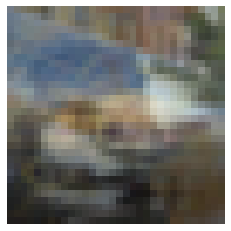

predicted image 1: 


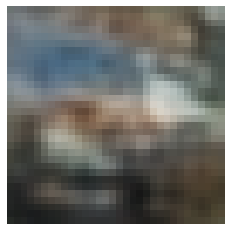

In [18]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("predicted image 1: ")
    imshow(bigger_encoder(inputs[0])[1])
    break

In [19]:
class BiggerAutoEncoder1(nn.Module):
    def __init__(self, encoder):
        super(BiggerAutoEncoder1, self).__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [20]:
def create_bigger_model1(encoder):
    autoencoder = BiggerAutoEncoder1(encoder)
    print_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder

In [21]:
big_autoencoder1 = create_bigger_model1(bigger_encoder.encoder)

============== Encoder ==============
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
)
============== Decoder ==============
Sequential(
  (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): Sigmoid()
)

Model moved to GPU in order to speed up training.


In [22]:
print("Loading checkpoint...")
big_autoencoder1.load_state_dict(torch.load("/kaggle/input/cifar10-encoder/weights/big_autoencoder1.pkl"))

Loading checkpoint...


<All keys matched successfully>

In [23]:
for index, param in enumerate(big_autoencoder1.parameters()):
    print(index, param.size(), param.requires_grad)

0 torch.Size([12, 3, 4, 4]) True
1 torch.Size([12]) True
2 torch.Size([24, 12, 4, 4]) True
3 torch.Size([24]) True
4 torch.Size([48, 24, 4, 4]) True
5 torch.Size([48]) True
6 torch.Size([96, 48, 4, 4]) True
7 torch.Size([96]) True
8 torch.Size([96, 48, 4, 4]) True
9 torch.Size([48]) True
10 torch.Size([48, 24, 4, 4]) True
11 torch.Size([24]) True
12 torch.Size([24, 12, 4, 4]) True
13 torch.Size([12]) True
14 torch.Size([12, 3, 4, 4]) True
15 torch.Size([3]) True


In [24]:
for index, param in enumerate(big_autoencoder1.parameters()):
    if index < 8:
        param.requires_grad = False

In [25]:
for index, param in enumerate(big_autoencoder1.parameters()):
    print(index, param.size(), param.requires_grad)

0 torch.Size([12, 3, 4, 4]) False
1 torch.Size([12]) False
2 torch.Size([24, 12, 4, 4]) False
3 torch.Size([24]) False
4 torch.Size([48, 24, 4, 4]) False
5 torch.Size([48]) False
6 torch.Size([96, 48, 4, 4]) False
7 torch.Size([96]) False
8 torch.Size([96, 48, 4, 4]) True
9 torch.Size([48]) True
10 torch.Size([48, 24, 4, 4]) True
11 torch.Size([24]) True
12 torch.Size([24, 12, 4, 4]) True
13 torch.Size([12]) True
14 torch.Size([12, 3, 4, 4]) True
15 torch.Size([3]) True


In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, big_autoencoder1.parameters()))
epochs = 20

In [29]:
epoch_counter = 0
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, (outputs1, outputs2)) in enumerate(custom_loader, 0):
        inputs = get_torch_vars(inputs)
        outputs1 = get_torch_vars(outputs1)
        outputs2 = get_torch_vars(outputs2)
        # ============ Forward ============
        encoded, outputs = big_autoencoder1(inputs)
        loss = criterion(outputs, outputs1)
        # ============ Backward ============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    if epoch_counter == 4:
        epoch_counter = -1
        if not os.path.exists('./weights'):
            os.mkdir('./weights')
        torch.save(big_autoencoder1.state_dict(), "./weights/big_autoencoder1.pkl")
    epoch_counter += 1
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(big_autoencoder1.state_dict(), "./weights/big_autoencoder1.pkl")

[1,  2000] loss: 0.02499
[1,  4000] loss: 0.02439
[1,  6000] loss: 0.02396
[1,  8000] loss: 0.02345
[1, 10000] loss: 0.02312
[1, 12000] loss: 0.02281
[1, 14000] loss: 0.02241
[2,  2000] loss: 0.02176
[2,  4000] loss: 0.02161
[2,  6000] loss: 0.02137
[2,  8000] loss: 0.02112
[2, 10000] loss: 0.02100
[2, 12000] loss: 0.02079
[2, 14000] loss: 0.02068
[3,  2000] loss: 0.02035
[3,  4000] loss: 0.02008
[3,  6000] loss: 0.02000
[3,  8000] loss: 0.01994
[3, 10000] loss: 0.01984
[3, 12000] loss: 0.01968
[3, 14000] loss: 0.01959
[4,  2000] loss: 0.01933
[4,  4000] loss: 0.01927
[4,  6000] loss: 0.01920
[4,  8000] loss: 0.01915
[4, 10000] loss: 0.01904
[4, 12000] loss: 0.01894
[4, 14000] loss: 0.01892
[5,  2000] loss: 0.01873
[5,  4000] loss: 0.01862
[5,  6000] loss: 0.01862
[5,  8000] loss: 0.01859
[5, 10000] loss: 0.01847
[5, 12000] loss: 0.01845
[5, 14000] loss: 0.01841
[6,  2000] loss: 0.01822
[6,  4000] loss: 0.01818
[6,  6000] loss: 0.01819
[6,  8000] loss: 0.01814
[6, 10000] loss: 0.01812


mean image: 


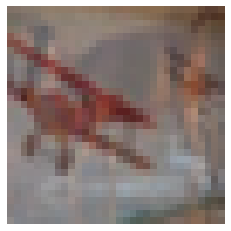

first image: 


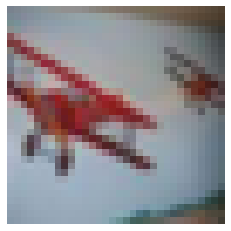

predicted image 1: 


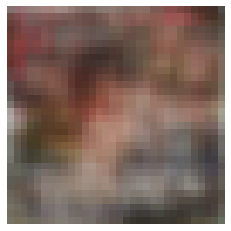

In [30]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("predicted image 1: ")
    imshow(big_autoencoder1(inputs[0])[1])
    break

In [31]:
big_autoencoder2 = create_bigger_model1(bigger_encoder.encoder)

============== Encoder ==============
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
)
============== Decoder ==============
Sequential(
  (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): Sigmoid()
)

Model moved to GPU in order to speed up training.


In [32]:
for index, param in enumerate(big_autoencoder2.parameters()):
    print(index, param.size(), param.requires_grad)

0 torch.Size([12, 3, 4, 4]) False
1 torch.Size([12]) False
2 torch.Size([24, 12, 4, 4]) False
3 torch.Size([24]) False
4 torch.Size([48, 24, 4, 4]) False
5 torch.Size([48]) False
6 torch.Size([96, 48, 4, 4]) False
7 torch.Size([96]) False
8 torch.Size([96, 48, 4, 4]) True
9 torch.Size([48]) True
10 torch.Size([48, 24, 4, 4]) True
11 torch.Size([24]) True
12 torch.Size([24, 12, 4, 4]) True
13 torch.Size([12]) True
14 torch.Size([12, 3, 4, 4]) True
15 torch.Size([3]) True


In [33]:
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, big_autoencoder2.parameters()))
epochs = 25

In [34]:
epoch_counter = 0
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, (outputs1, outputs2)) in enumerate(custom_loader, 0):
        inputs = get_torch_vars(inputs)
        outputs1 = get_torch_vars(outputs1)
        outputs2 = get_torch_vars(outputs2)
        # ============ Forward ============
        encoded, outputs = big_autoencoder2(inputs)
        loss = criterion(outputs, outputs2)
        # ============ Backward ============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    if epoch_counter == 4:
        epoch_counter = -1
        if not os.path.exists('./weights'):
            os.mkdir('./weights')
        torch.save(big_autoencoder2.state_dict(), "./weights/big_autoencoder2.pkl")
    epoch_counter += 1
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(big_autoencoder2.state_dict(), "./weights/big_autoencoder2.pkl")

[1,  2000] loss: 0.03958
[1,  4000] loss: 0.03288
[1,  6000] loss: 0.03000
[1,  8000] loss: 0.02764
[1, 10000] loss: 0.02594
[1, 12000] loss: 0.02453
[1, 14000] loss: 0.02346
[2,  2000] loss: 0.02196
[2,  4000] loss: 0.02148
[2,  6000] loss: 0.02108
[2,  8000] loss: 0.02067
[2, 10000] loss: 0.02026
[2, 12000] loss: 0.01996
[2, 14000] loss: 0.01975
[3,  2000] loss: 0.01929
[3,  4000] loss: 0.01914
[3,  6000] loss: 0.01895
[3,  8000] loss: 0.01882
[3, 10000] loss: 0.01876
[3, 12000] loss: 0.01851
[3, 14000] loss: 0.01843
[4,  2000] loss: 0.01825
[4,  4000] loss: 0.01810
[4,  6000] loss: 0.01795
[4,  8000] loss: 0.01795
[4, 10000] loss: 0.01791
[4, 12000] loss: 0.01786
[4, 14000] loss: 0.01779
[5,  2000] loss: 0.01757
[5,  4000] loss: 0.01759
[5,  6000] loss: 0.01748
[5,  8000] loss: 0.01749
[5, 10000] loss: 0.01736
[5, 12000] loss: 0.01729
[5, 14000] loss: 0.01732
[6,  2000] loss: 0.01720
[6,  4000] loss: 0.01708
[6,  6000] loss: 0.01714
[6,  8000] loss: 0.01718
[6, 10000] loss: 0.01709


mean image: 


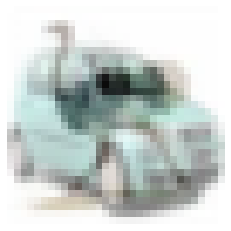

second image: 


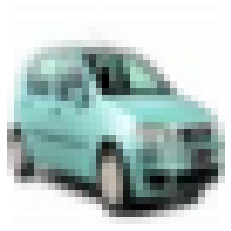

predicted image 1: 


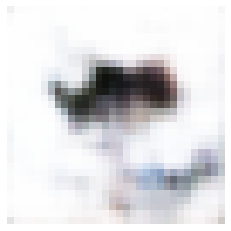

In [35]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image 1: ")
    imshow(big_autoencoder2(inputs[0])[1])
    break

In [40]:
class BigMainAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder1, decoder2):
        super(BigMainAutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder1 = decoder1
        self.decoder2 = decoder2
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded1 = self.decoder1(encoded)
        decoded2 = self.decoder2(encoded)
        return encoded, decoded1, decoded2

In [41]:
def create_big_main_model(encoder, decoder1, decoder2):
    autoencoder = BigMainAutoEncoder(encoder, decoder1, decoder2)
#     print_model(autoencoder.encoder, autoencoder.decoder1, autoencoder.decoder2)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU in order to speed up training.")
    return autoencoder

In [42]:
main_model = create_big_main_model(bigger_encoder.encoder, big_autoencoder1.decoder, big_autoencoder2.decoder)
main_model

Model moved to GPU in order to speed up training.


BigMainAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder1): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
  (decoder2): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(48, 2

In [43]:
for index, param in enumerate(main_model.parameters()):
    print(index, param.size(), param.requires_grad)

0 torch.Size([12, 3, 4, 4]) False
1 torch.Size([12]) False
2 torch.Size([24, 12, 4, 4]) False
3 torch.Size([24]) False
4 torch.Size([48, 24, 4, 4]) False
5 torch.Size([48]) False
6 torch.Size([96, 48, 4, 4]) False
7 torch.Size([96]) False
8 torch.Size([96, 48, 4, 4]) True
9 torch.Size([48]) True
10 torch.Size([48, 24, 4, 4]) True
11 torch.Size([24]) True
12 torch.Size([24, 12, 4, 4]) True
13 torch.Size([12]) True
14 torch.Size([12, 3, 4, 4]) True
15 torch.Size([3]) True
16 torch.Size([96, 48, 4, 4]) True
17 torch.Size([48]) True
18 torch.Size([48, 24, 4, 4]) True
19 torch.Size([24]) True
20 torch.Size([24, 12, 4, 4]) True
21 torch.Size([12]) True
22 torch.Size([12, 3, 4, 4]) True
23 torch.Size([3]) True


In [44]:
for index, param in enumerate(main_model.parameters()):
    param.requires_grad = True

In [45]:
for index, param in enumerate(main_model.parameters()):
    print(index, param.size(), param.requires_grad)

0 torch.Size([12, 3, 4, 4]) True
1 torch.Size([12]) True
2 torch.Size([24, 12, 4, 4]) True
3 torch.Size([24]) True
4 torch.Size([48, 24, 4, 4]) True
5 torch.Size([48]) True
6 torch.Size([96, 48, 4, 4]) True
7 torch.Size([96]) True
8 torch.Size([96, 48, 4, 4]) True
9 torch.Size([48]) True
10 torch.Size([48, 24, 4, 4]) True
11 torch.Size([24]) True
12 torch.Size([24, 12, 4, 4]) True
13 torch.Size([12]) True
14 torch.Size([12, 3, 4, 4]) True
15 torch.Size([3]) True
16 torch.Size([96, 48, 4, 4]) True
17 torch.Size([48]) True
18 torch.Size([48, 24, 4, 4]) True
19 torch.Size([24]) True
20 torch.Size([24, 12, 4, 4]) True
21 torch.Size([12]) True
22 torch.Size([12, 3, 4, 4]) True
23 torch.Size([3]) True


In [46]:
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, main_model.parameters()))
epochs = 25

In [47]:
epoch_counter = 0
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, (outputs1, outputs2)) in enumerate(custom_loader, 0):
        inputs = get_torch_vars(inputs)
        outputs1 = get_torch_vars(outputs1)
        outputs2 = get_torch_vars(outputs2)
        # ============ Forward ============
        encoded, output1, output2 = main_model(inputs)
        loss = (criterion(output1, outputs1) + criterion(output2, outputs2)) / 2
        # ============ Backward ============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ============ Logging ============
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    epoch_counter += 1
    if epoch_counter == 4:
        if not os.path.exists('./weights'):
            os.mkdir('./weights')
        torch.save(main_model.state_dict(), "./weights/big_main_model.pkl")
        epoch_counter = -1
print('Finished Training')
print('Saving Model...')
if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(main_model.state_dict(), "./weights/big_main_model.pkl")

[1,  2000] loss: 0.01714
[1,  4000] loss: 0.01637
[1,  6000] loss: 0.01604
[1,  8000] loss: 0.01583
[1, 10000] loss: 0.01555
[1, 12000] loss: 0.01532
[1, 14000] loss: 0.01515
[2,  2000] loss: 0.01473
[2,  4000] loss: 0.01464
[2,  6000] loss: 0.01442
[2,  8000] loss: 0.01435
[2, 10000] loss: 0.01419
[2, 12000] loss: 0.01401
[2, 14000] loss: 0.01395
[3,  2000] loss: 0.01366
[3,  4000] loss: 0.01358
[3,  6000] loss: 0.01349
[3,  8000] loss: 0.01336
[3, 10000] loss: 0.01334
[3, 12000] loss: 0.01319
[3, 14000] loss: 0.01305
[4,  2000] loss: 0.01293
[4,  4000] loss: 0.01288
[4,  6000] loss: 0.01279
[4,  8000] loss: 0.01274
[4, 10000] loss: 0.01265
[4, 12000] loss: 0.01259
[4, 14000] loss: 0.01251
[5,  2000] loss: 0.01240
[5,  4000] loss: 0.01233
[5,  6000] loss: 0.01229
[5,  8000] loss: 0.01222
[5, 10000] loss: 0.01217
[5, 12000] loss: 0.01212
[5, 14000] loss: 0.01209
[6,  2000] loss: 0.01197
[6,  4000] loss: 0.01192
[6,  6000] loss: 0.01191
[6,  8000] loss: 0.01183
[6, 10000] loss: 0.01184


mean image: 


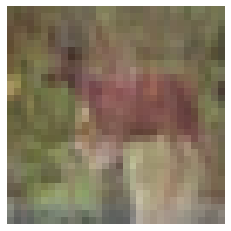

first image: 


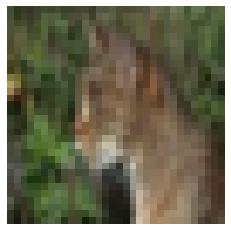

second image: 


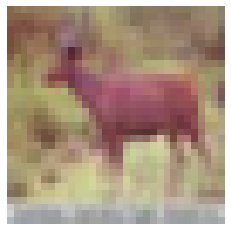

predicted image 1: 


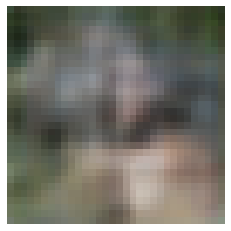

predicted image 2: 


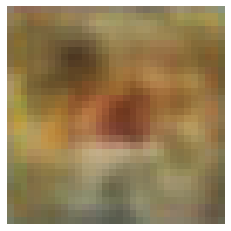

loss:  tensor(0.0247, device='cuda:0', grad_fn=<DivBackward0>)


In [53]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image 1: ")
    imshow(main_model(inputs[0])[1])
    print("predicted image 2: ")
    imshow(main_model(inputs[0])[2])
    loss = (criterion(main_model(inputs[0])[1], outputs1[0]) + criterion(main_model(inputs[0])[2], outputs2[0])) / 2
    print("loss: ", loss)
    break

mean image: 


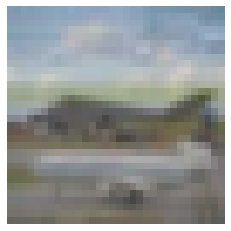

first image: 


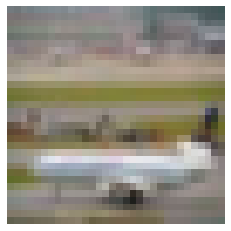

second image: 


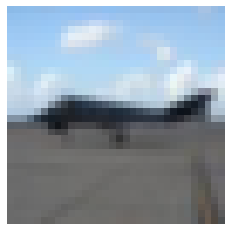

predicted image 1: 


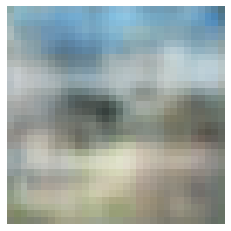

predicted image 2: 


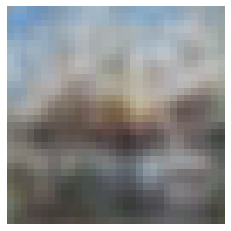

loss:  tensor(0.0256, device='cuda:0', grad_fn=<DivBackward0>)


In [69]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image 1: ")
    imshow(main_model(inputs[0])[1])
    print("predicted image 2: ")
    imshow(main_model(inputs[0])[2])
    loss = (criterion(main_model(inputs[0])[1], outputs1[0]) + criterion(main_model(inputs[0])[2], outputs2[0])) / 2
    print("loss: ", loss)
    break

mean image: 


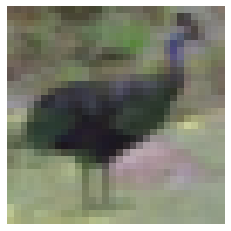

first image: 


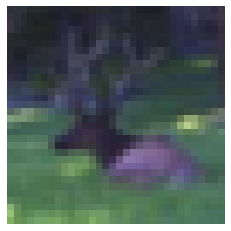

second image: 


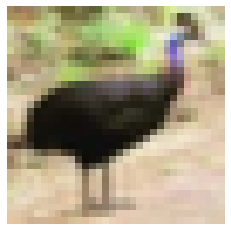

predicted image 1: 


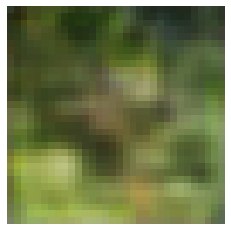

predicted image 2: 


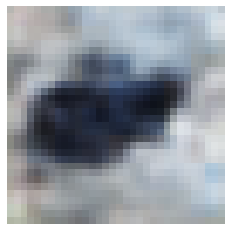

loss:  tensor(0.0242, device='cuda:0', grad_fn=<DivBackward0>)


In [70]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image 1: ")
    imshow(main_model(inputs[0])[1])
    print("predicted image 2: ")
    imshow(main_model(inputs[0])[2])
    loss = (criterion(main_model(inputs[0])[1], outputs1[0]) + criterion(main_model(inputs[0])[2], outputs2[0])) / 2
    print("loss: ", loss)
    break

mean image: 


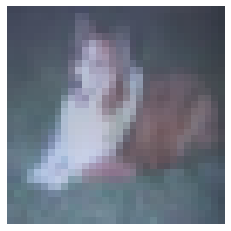

first image: 


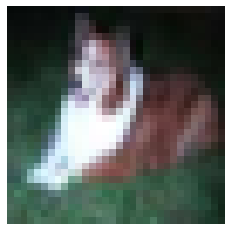

second image: 


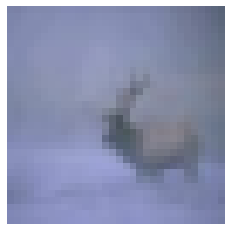

predicted image 1: 


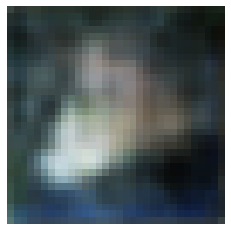

predicted image 2: 


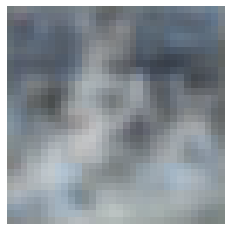

loss:  tensor(0.0216, device='cuda:0', grad_fn=<DivBackward0>)


In [78]:
for i, (inputs, (outputs1, outputs2)) in enumerate(test_loader, 0):
    inputs = get_torch_vars(inputs)
    outputs1 = get_torch_vars(outputs1)
    outputs2 = get_torch_vars(outputs2)
    print("mean image: ")
    imshow(inputs[0])
    print("first image: ")
    imshow(outputs1[0])
    print("second image: ")
    imshow(outputs2[0])
    print("predicted image 1: ")
    imshow(main_model(inputs[0])[1])
    print("predicted image 2: ")
    imshow(main_model(inputs[0])[2])
    loss = (criterion(main_model(inputs[0])[1], outputs1[0]) + criterion(main_model(inputs[0])[2], outputs2[0])) / 2
    print("loss: ", loss)
    break